# Zero-shot image classification 

1. Load data of Animal with attributes from https://www.mpi-inf.mpg.de/departments/computer-vision-and-multimodal-computing/research/zero-shot-learning/zero-shot-learning-the-good-the-bad-and-the-ugly/
2. Prepare data (three splits train, val, and test)
3. Implement SJE train, predict, and evaluate

[Akata, et al. CVPR2015]
[Xian, et al. CVPR2017]

In [1]:
import scipy.io as spio


image_info = spio.loadmat('Data/xlsa17/data/AWA2/res101.mat')
class_info = spio.loadmat('Data/xlsa17/data/AWA2/att_splits.mat')

In [ ]:
# image_info['features'] # all image features
# image_info['labels'] # all image labels

# class_info['att'] # class embeddings
# class_info['train_loc'] # seen class images (training)
# class_info['val_loc'] # seen class images (val)
# class_info['test_unseen_loc'] # unseen class images

In [ ]:
import scipy.io as spio
import numpy as np
import datetime
import random
from collections import Counter

def l2_norm(x):
    return x / (np.linalg.norm(x)+ 10e-6)

image_info = spio.loadmat('Data/xlsa17/data/AWA2/res101.mat')
class_info = spio.loadmat('Data/xlsa17/data/AWA2/att_splits.mat')

In [2]:
### Prepare data
tr_labels, val_labels, test_labels = [], [], []
# training data
X, Y = [], []
for idx in class_info['train_loc']:
    X.append(l2_norm(image_info['features'].transpose()[idx[0]-1]))
    Y.append(image_info['labels'][idx[0]-1][0]-1)
    if not image_info['labels'][idx[0]-1][0]-1 in tr_labels:
        tr_labels.append(image_info['labels'][idx[0]-1][0]-1)
# val data
val_X, val_Y = [], []
for idx in class_info['val_loc']:
    val_X.append(l2_norm(image_info['features'].transpose()[idx[0]-1]))
    val_Y.append(image_info['labels'][idx[0]-1][0]-1)
    if not image_info['labels'][idx[0]-1][0]-1 in val_labels:
        val_labels.append(image_info['labels'][idx[0]-1][0]-1)
# test data
test_X, test_Y = [], []
for idx in class_info['test_unseen_loc']:
    test_X.append(l2_norm(image_info['features'].transpose()[idx[0]-1]))
    test_Y.append(image_info['labels'][idx[0]-1][0]-1)
    if not image_info['labels'][idx[0]-1][0]-1 in test_labels:
        test_labels.append(image_info['labels'][idx[0]-1][0]-1)

# get all classes embeddings
class_embeddings = class_info['att'].transpose()
# dims of image features and class embeddings
x_dim, yEmb_dim = len(X[0]), len(class_embeddings[0])

In [15]:
# class split 
tr_classes, val_classes, test_classes= [], [], []
print "training classes:"
for idx in tr_labels:
    tr_classes.append(class_info['allclasses_names'][idx][0][0])
    print class_info['allclasses_names'][idx][0][0], ',',
print "\nvalidation classes:"
for idx in val_labels:
    val_classes.append(class_info['allclasses_names'][idx][0][0])
    print class_info['allclasses_names'][idx][0][0], ',',
print "\ntest classes:"
for idx in test_labels:
    test_classes.append(class_info['allclasses_names'][idx][0][0])
    print class_info['allclasses_names'][idx][0][0], ',',

training classes:
antelope , buffalo , chihuahua , collie , cow , elephant , fox , german+shepherd , grizzly+bear , hippopotamus , humpback+whale , killer+whale , lion , mouse , otter , persian+cat , pig , polar+bear , rhinoceros , siamese+cat , skunk , spider+monkey , squirrel , tiger , weasel , wolf , zebra , 
validation classes:
beaver , chimpanzee , dalmatian , deer , giant+panda , gorilla , hamster , leopard , mole , moose , ox , rabbit , raccoon , 
test classes:
bat , blue+whale , bobcat , dolphin , giraffe , horse , rat , seal , sheep , walrus ,


In [ ]:
# initialize your weights matrix
for e in epochs:
    # shuffle your samples
    for i in range(len(samples)):
        x_i, y_true = X[i], Y[i]
        score_true = # calculate score with true label 
        
        max_score, max_y_tr = -1, -1
        for y_tr in tr_labels: 
            score =  # calculate score with y_tr label
            loss = Delta(y_tr,y_true) + score_true - score
            if score > max_score:
                # update max_score & max_y_tr
        
        if not max_index  == y_true : # violation!
            W = W - learning_rate * X [phi(y_true) - phi(max_y_tr)]

In [4]:
def train(X,Y,LR,T,W=None):
    
    # total number of training samples
    N = len(X)
    
    # initialize the joint embedding matrix W: is x_dim x y_dim where x_dim is input embedding dimension and yEmb_dim is the output embedding dimension
    # the initialization value is equal to 1 
    if W is None:
        W = np.ones((x_dim, yEmb_dim))
    
    # SGD train the weights with T iteration using LR
    Indices= list(range(0,N))
    for t in range(0,T):
        
        ep_start = datetime.datetime.now()
        ep_loss = 0
        random.shuffle(Indices)
        for index in range(0,N):
            n = Indices[index] # pick a random sample n
            max_loss = 0 # max loaa
            max_j = -1 # max_j keeps the index of the max rank

            inputP= l2_norm(np.dot(np.transpose(X[n]),W)) # project input on joint embedding space
            comp_true = np.dot(inputP,class_embeddings[Y[n]]) 
            
            for j in tr_labels: # iterate over tr classes to find the one with the maximum rank
                delta = 0 if Y[n] == j else 1 # 0-1 loss
                comp = np.dot(inputP,class_embeddings[j]) # compatability between input projection and class_embeddings[j]
                loss = delta + comp - comp_true
                if loss > max_loss:
                    max_loss = loss
                    max_j = j
            
            ep_loss += max_loss
            
            # update weights if violation
            if not (max_j == Y[n]):
                tranX = np.array(X[n])[np.newaxis]
                W = np.subtract(W, LR * np.dot(tranX.T,  np.array(class_embeddings[max_j])[np.newaxis]))
                W = np.add(W, LR * np.dot(tranX.T,  np.array(class_embeddings[Y[n]])[np.newaxis]))
                
        val_acc, val_class_acc = evaluate(val_X, val_Y,val_labels,W)
        ep_end = datetime.datetime.now()
        print "Epoch {}/{}".format(t,T)
        print "{}s training loss {} validation accuracy {} class accuracy {}".format(ep_end-ep_start,ep_loss/N,val_acc,val_class_acc)
    return W

In [ ]:
def predict(x,test_class_indices,W):
    max_comp = -1
    max_i = -1
    inputP = l2_norm(np.dot(np.transpose(x),W)) # project input on joint embedding space
        
    for i in test_class_indices: 
        comp = np.dot(inputP,class_embeddings[i])
        if comp > max_comp:
            max_comp = comp
            max_i = i
    return max_i

In [ ]:
def evaluate(X,Y,test_class_indices,W):
    correct_pred = 0
    class_correct_pred = {t:0 for t in test_class_indices}
    for n in range(len(X)):
        pred_label = predict(X[n],test_class_indices,W)
        if pred_label == Y[n]:
            correct_pred += 1
            class_correct_pred[Y[n]] +=1
    class_counts = Counter(Y)
    acc = float(correct_pred) / len(X)
    class_acc = np.mean([float(class_correct_pred[k])/class_counts[k] for k in class_counts.keys() ]) 
    return acc, class_acc

In [10]:
import matplotlib.pyplot as plt

def parse_log_file(pfile):
    f= open(pfile).readlines()
    lines = [i.strip() for i in f]
    log= {k:[] for k in ['validation accuracy','class accuracy','loss']}
    for l in lines:
        if 'loss' in l:
            for k in log.keys():
                log[k].append(float(l.split(k+' ')[1].split(' ')[0]))
    return log 

def plot_loss_acc(pfile):
    history = parse_log_file(pfile)
    plt.plot(history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    plt.plot(history['validation accuracy'])
    plt.plot(history['class accuracy'])
    plt.title('model acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['val_acc', 'val_class_acc'], loc='upper left')
    plt.show()

In [5]:
st = datetime.datetime.now()
W = train(X,Y,0.1,50)
end = datetime.datetime.now()
duration = end - st
print "training time {}".format(duration)
print "test accuracy {}".format(evaluate(test_X,test_Y,test_labels,W))
np.save('new_trained_w_50ep_0.1LR.npy',W)

Epoch 0/50
0:01:22.910288s training loss 0.898996540245 validation accuracy 0.158959852029 class accuracy 0.139098925673
Epoch 1/50
0:01:21.303714s training loss 0.886730972881 validation accuracy 0.226852355565 class accuracy 0.202837203075
Epoch 2/50
0:01:21.508663s training loss 0.870513019359 validation accuracy 0.304210640844 class accuracy 0.282379118712
Epoch 3/50
0:01:21.739325s training loss 0.852204324311 validation accuracy 0.35360678925 class accuracy 0.357437575613
Epoch 4/50
0:01:23.551731s training loss 0.834893717013 validation accuracy 0.394842780981 class accuracy 0.41208837704
Epoch 5/50
0:01:23.360776s training loss 0.817994516528 validation accuracy 0.447067783701 class accuracy 0.4624822674
Epoch 6/50
0:01:22.833895s training loss 0.801626994786 validation accuracy 0.495484713306 class accuracy 0.508410288671
Epoch 7/50
0:01:25.891981s training loss 0.785718332586 validation accuracy 0.516157110217 class accuracy 0.525815072581
Epoch 8/50
0:01:27.195496s training 

In [6]:
# reported result is 67% acc
# ~ around 1 hours training on CPU with ~ 55% test accuracy (random chance is 10%)


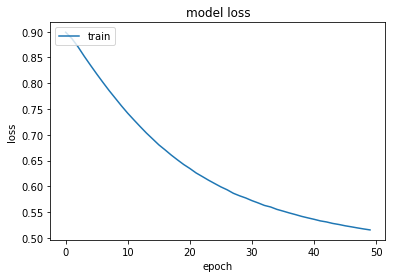

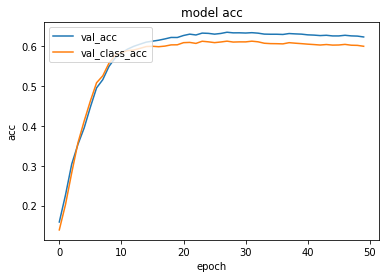

In [11]:
plot_loss_acc('sje log')